In [174]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [175]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/grap

In [176]:
from konlpy.tag import Mecab
tokenizer = Mecab()

tokenizer.morphs("민락동에서 가장 맛있는 텐동집이 어디인가요?")

['민락동', '에서', '가장', '맛있', '는', '텐동', '집', '이', '어디', '인가요', '?']

In [177]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [178]:
train_data = pd.read_table('/content/drive/MyDrive/Colab Notebooks/Aiffel/Exploration/Exploration7/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Colab Notebooks/Aiffel/Exploration/Exploration7/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [179]:
len(train_data)

150000

In [180]:
len(test_data)

50000

In [181]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [182]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [183]:
len(X_train)

146182

In [184]:
len(X_test)

49157

In [185]:
# from konlpy.tag import Mecab
# tokenizer = Mecab()
# stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', ',으로', '자', '에', '와', '한', '하다']

# def load_data(train_data, test_data, num_words=10000):
#   train_data.drop_duplicates(subset=['document'], inplace=True)
#   train_data = train_data.dropna(how='any')
#   test_data.drop_duplicates(subset=['document'], inplace=True)
#   test_data = test_data.dropna(how = 'any')

#   X_train = []
#   for sentence in train_data['document']:
#     temp_X = tokenizer.morphs(sentence)
#     temp_X = [word for word in temp_X if not word in stopwords]
#     X_train.append(temp_X)

#   X_test = []
#   for sentence in test_data['document']:
#     temp_X = tokenizer.morphs(sentence)
#     temp_X = [word for word in temp_X if not word in stopwords]
#     X_test.append(temp_X)

#     words = np.concatenate(X_train).tolist()
#     counter = Counter(words)
#     counter = counter.most_common(10000-4)
#     vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
#     word_to_index = {word:index for index, word in enumerate(vocab)}


#     def wordlist_to_indexlist(wordlist):
#       return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
#     X_train = list(map(wordlist_to_indexlist, X_train))
#     X_test = list(map(wordlist_to_indexlist, X_test))

#     return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

# X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [186]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [187]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [188]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균:', np.mean(num_tokens))
print('문장길이 최대:', np.max(num_tokens))
print('문장길이 표준편차:', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen:', maxlen)
print('전체 문장의 {}%가 포함됩니다.' .format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균: 15.969376315021577
문장길이 최대: 116
문장길이 표준편차: 12.843535456326455
pad_sequences maxlen: 41
전체 문장의 0.9342988343341575%가 포함됩니다.


In [189]:
X_train = get_encoded_sentences(X_train, word_to_index)

In [190]:
X_test = get_encoded_sentences(X_test, word_to_index)

In [191]:
raw_inputs = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre',
                                                        maxlen=maxlen)
print(raw_inputs)

[[0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 ...
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]]


In [192]:
X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre',
                                                        maxlen=maxlen)
print(X_test)

[[0 0 0 ... 1 2 2]
 [0 0 0 ... 0 1 2]
 [0 0 0 ... 2 2 2]
 ...
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]]


In [193]:
import numpy as np
import tensorflow as tf

vocab_size = len(word_to_index)
word_vector_dim = 4

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre',
                                                        maxlen=maxlen)

output = embedding(X_train)
print(output)

tf.Tensor(
[[[ 9.9172220e-03  1.9972373e-02 -2.1991288e-02  3.4207430e-02]
  [ 9.9172220e-03  1.9972373e-02 -2.1991288e-02  3.4207430e-02]
  [ 9.9172220e-03  1.9972373e-02 -2.1991288e-02  3.4207430e-02]
  ...
  [ 1.3348307e-02 -4.3780901e-02 -2.8126443e-02 -5.7108700e-06]
  [ 1.3348307e-02 -4.3780901e-02 -2.8126443e-02 -5.7108700e-06]
  [ 1.3348307e-02 -4.3780901e-02 -2.8126443e-02 -5.7108700e-06]]

 [[ 9.9172220e-03  1.9972373e-02 -2.1991288e-02  3.4207430e-02]
  [ 9.9172220e-03  1.9972373e-02 -2.1991288e-02  3.4207430e-02]
  [ 9.9172220e-03  1.9972373e-02 -2.1991288e-02  3.4207430e-02]
  ...
  [ 1.3348307e-02 -4.3780901e-02 -2.8126443e-02 -5.7108700e-06]
  [ 1.3348307e-02 -4.3780901e-02 -2.8126443e-02 -5.7108700e-06]
  [ 1.3348307e-02 -4.3780901e-02 -2.8126443e-02 -5.7108700e-06]]

 [[ 9.9172220e-03  1.9972373e-02 -2.1991288e-02  3.4207430e-02]
  [ 9.9172220e-03  1.9972373e-02 -2.1991288e-02  3.4207430e-02]
  [ 9.9172220e-03  1.9972373e-02 -2.1991288e-02  3.4207430e-02]
  ...
  [ 1.3

In [194]:
import numpy as np
import tensorflow as tf

vocab_size = len(word_to_index)
word_vector_dim = 4

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre',
                                                        maxlen=maxlen)

output = embedding(X_train)
print(output)

tf.Tensor(
[[[-0.03015235  0.00226247 -0.03457129 -0.01612772]
  [-0.03015235  0.00226247 -0.03457129 -0.01612772]
  [-0.03015235  0.00226247 -0.03457129 -0.01612772]
  ...
  [-0.04312113  0.004467   -0.02426013  0.01442939]
  [-0.04312113  0.004467   -0.02426013  0.01442939]
  [-0.04312113  0.004467   -0.02426013  0.01442939]]

 [[-0.03015235  0.00226247 -0.03457129 -0.01612772]
  [-0.03015235  0.00226247 -0.03457129 -0.01612772]
  [-0.03015235  0.00226247 -0.03457129 -0.01612772]
  ...
  [-0.04312113  0.004467   -0.02426013  0.01442939]
  [-0.04312113  0.004467   -0.02426013  0.01442939]
  [-0.04312113  0.004467   -0.02426013  0.01442939]]

 [[-0.03015235  0.00226247 -0.03457129 -0.01612772]
  [-0.03015235  0.00226247 -0.03457129 -0.01612772]
  [-0.03015235  0.00226247 -0.03457129 -0.01612772]
  ...
  [-0.04312113  0.004467   -0.02426013  0.01442939]
  [-0.04312113  0.004467   -0.02426013  0.01442939]
  [-0.04312113  0.004467   -0.02426013  0.01442939]]

 ...

 [[-0.03015235  0.00226

In [195]:
output.shape

TensorShape([146182, 41, 4])

In [196]:
len(X_train)

146182

In [197]:
# validation set 10000건 분리
X_val = X_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[40000:]  
partial_y_train = y_train[40000:]

## 모델 훈련

RNN

In [198]:
vocab_size = 146182    
word_vector_dim = 4 

model = keras.Sequential()

model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, None, 4)           584728    
_________________________________________________________________
lstm_11 (LSTM)               (None, 8)                 416       
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 9         
Total params: 585,225
Trainable params: 585,225
Non-trainable params: 0
_________________________________________________________________


In [206]:
model.compile(optimizer = 'adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
208/208 [==============================] - 3s 13ms/step - loss: 0.6927 - accuracy: 0.5082 - val_loss: 0.6927 - val_accuracy: 0.5056
Epoch 2/20
208/208 [==============================] - 2s 12ms/step - loss: 0.6927 - accuracy: 0.5094 - val_loss: 0.6927 - val_accuracy: 0.5060
Epoch 3/20
208/208 [==============================] - 2s 12ms/step - loss: 0.6927 - accuracy: 0.5086 - val_loss: 0.6927 - val_accuracy: 0.5059
Epoch 4/20
208/208 [==============================] - 2s 11ms/step - loss: 0.6927 - accuracy: 0.5085 - val_loss: 0.6928 - val_accuracy: 0.5053
Epoch 5/20
208/208 [==============================] - 2s 11ms/step - loss: 0.6927 - accuracy: 0.5080 - val_loss: 0.6927 - val_accuracy: 0.5078
Epoch 6/20
208/208 [==============================] - 2s 12ms/step - loss: 0.6927 - accuracy: 0.5072 - val_loss: 0.6928 - val_accuracy: 0.5034
Epoch 7/20
208/208 [==============================] - 2s 12ms/step - loss: 0.6927 - accuracy: 0.5092 - val_loss: 0.6927 - val_accuracy: 0.5059

In [208]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.6927 - accuracy: 0.5070
[0.6926872730255127, 0.5070285201072693]


CNN

In [209]:
vocab_size = 146182  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, None, 4)           584728    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 16)          464       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 16)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_33 (Dense)             (None, 1)               

In [210]:
model.compile(optimizer = 'adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
208/208 [==============================] - 3s 12ms/step - loss: 0.6930 - accuracy: 0.5050 - val_loss: 0.6929 - val_accuracy: 0.5002
Epoch 2/20
208/208 [==============================] - 3s 12ms/step - loss: 0.6928 - accuracy: 0.5055 - val_loss: 0.6928 - val_accuracy: 0.5092
Epoch 3/20
208/208 [==============================] - 3s 12ms/step - loss: 0.6928 - accuracy: 0.5071 - val_loss: 0.6928 - val_accuracy: 0.5002
Epoch 4/20
208/208 [==============================] - 3s 12ms/step - loss: 0.6928 - accuracy: 0.5033 - val_loss: 0.6927 - val_accuracy: 0.5074
Epoch 5/20
208/208 [==============================] - 3s 12ms/step - loss: 0.6928 - accuracy: 0.5059 - val_loss: 0.6927 - val_accuracy: 0.5109
Epoch 6/20
208/208 [==============================] - 2s 12ms/step - loss: 0.6928 - accuracy: 0.5068 - val_loss: 0.6927 - val_accuracy: 0.5110
Epoch 7/20
208/208 [==============================] - 2s 12ms/step - loss: 0.6928 - accuracy: 0.5058 - val_loss: 0.6927 - val_accuracy: 0.5109

In [211]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.6927 - accuracy: 0.5076
[0.6926714777946472, 0.5076388120651245]


In [212]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


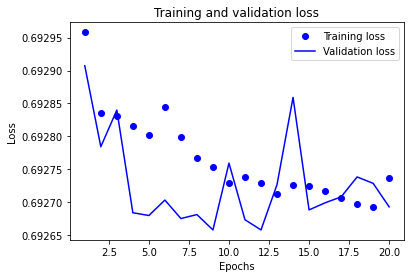

In [213]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

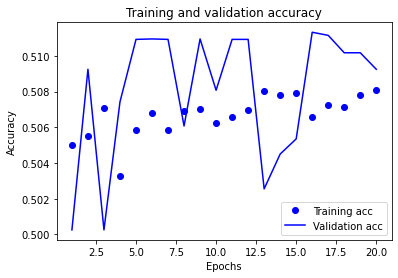

In [214]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()